In [158]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
import pymc as pm


project_dir = Path.cwd().parent
train_df = pd.read_csv(project_dir / "data" / "model" / "training_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)


train_df['y'] = train_df.sum(axis=1)
train_df.index = pd.to_datetime(train_df.index)
train_df.index.freq = train_df.index.inferred_freq


In [159]:
train_df

,delay_0,delay_1,delay_2,delay_3,delay_4,delay_5,delay_6,delay_7,delay_8,delay_9,...,delay_31,delay_32,delay_33,delay_34,delay_35,delay_36,delay_37,delay_38,delay_39,y
Date_Symptoms,,,,,,,,,,,,,,,,,,,,,
2013-02-10,108,182,131,203,207,146,38,28,119,53,...,2,0,0,0,0,1,1,1,0,1394
2013-02-11,127,184,184,230,190,48,37,157,60,42,...,1,1,0,0,0,0,1,0,1,1421
2013-02-12,112,243,261,225,60,44,196,91,77,39,...,0,0,0,3,1,0,1,0,0,1497
2013-02-13,169,325,287,102,74,206,114,129,74,54,...,0,0,1,0,0,0,0,0,0,1666
2013-02-14,184,375,122,91,214,135,136,123,58,1,...,0,0,3,1,1,2,0,0,0,1582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-18,14,15,22,3,4,13,7,12,5,3,...,1,0,1,0,0,0,0,0,0,113
2018-07-19,7,22,8,7,15,6,8,7,4,0,...,0,0,0,1,0,0,0,0,0,96
2018-07-20,5,15,5,25,13,8,7,9,2,1,...,0,0,1,2,0,0,0,0,0,112


Timestamp('2015-01-25 00:00:00')

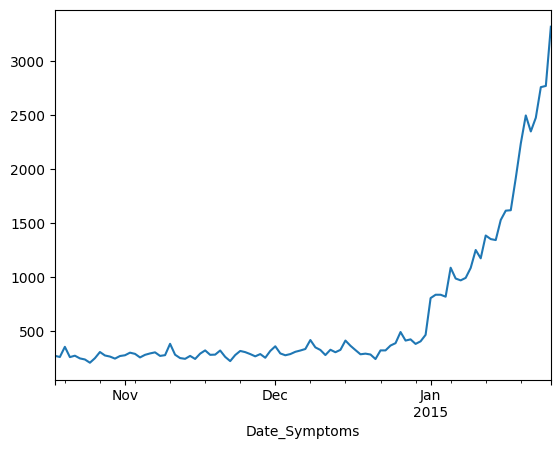

In [162]:
import yaml

# Load config vars
with open( project_dir / "config.yaml", 'r') as f:
    config = yaml.safe_load(f)

MAX_DELAY = config['model']['max_delay']


D = MAX_DELAY
N = len(train_df) - D + 1
reporting_matrices = np.empty((N, D, D))

def mask_matrix(matrix):
        masked_matrix = matrix.copy()
        nrow, ncol = masked_matrix.shape

        for i in range(nrow):
            for j in range(ncol):
                if i + j > D - 1:
                     masked_matrix[i, j] = 0
        return  masked_matrix

start_index = 615
length = 100
data = train_df[start_index:start_index+length]
y = data['y']
y.plot()
Z = data.drop('y', axis=1)
Z[-D:] = mask_matrix(np.array(Z[-D:]))

y_obs = np.array(Z).sum(axis=1)
y.index[-1]

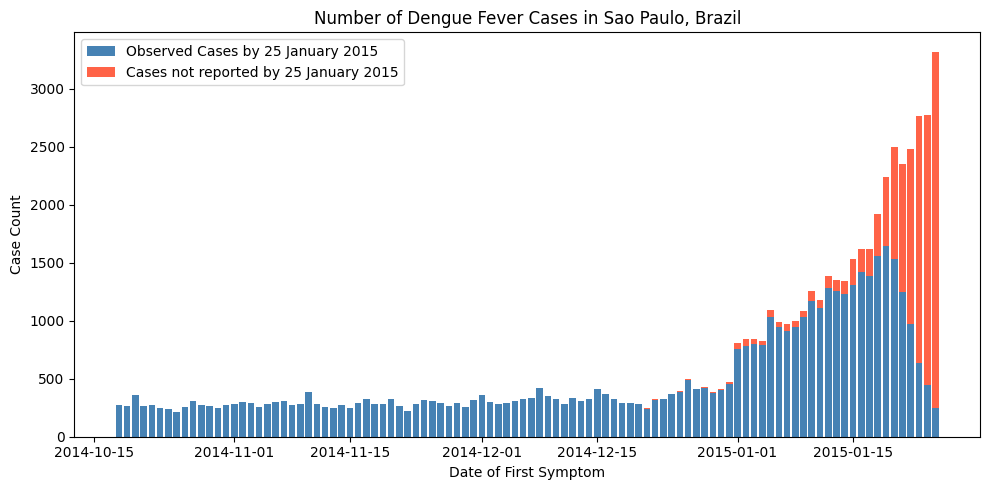

In [171]:
# Compute the under-reported portion
y_gap = y - y_obs

# X-axis positions
x = np.arange(len(y))

# Plot stacked bars
plt.figure(figsize=(10, 5))
plt.bar(y.index, y_obs, color="steelblue", label=f"Observed Cases by {y.index[-1].strftime("%d %B %Y")}")
plt.bar(y.index, y_gap, bottom=y_obs, color="tomato", label=f"Cases not reported by {y.index[-1].strftime("%d %B %Y")}")

plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
plt.legend()
plt.tight_layout()
plt.show()